・16×16のイジングスピン配位を生成する関数を作成

・T=0からT=6までの0.25刻みの温度で配位データを1000ずつ取得

version2

１．温度ではなく逆温度を使う

２．取得するデータの範囲をbeta=0.2からbeta=1の100刻みにする

In [1]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import pickle
import os

In [2]:
# 磁化が負の場合にスピン全体を反転する関数
def reverse(Spin):
    Magnetization = Spin.sum()
    if Magnetization < 0:
        Spin = -Spin
    return Spin

In [3]:
# メトロポリス法の関数
def metropolis_ising(L, beta, num_steps, J=1, device="cpu"):
    lattice = np.random.choice([-1, 1], size=(L, L))
    
    for step in range(num_steps):
        i = np.random.randint(L)
        j = np.random.randint(L)
        
        
        # 近傍のスピンの総和を計算（周期境界条件を適用）
        total = lattice[(i + 1) % L, j] + lattice[(i - 1) % L, j] + \
                lattice[i, (j + 1) % L] + lattice[i, (j - 1) % L]
        
        # エネルギー差を計算
        delta_energy = 2 * J * lattice[i, j] * total
        
        if delta_energy < 0 or np.random.rand() < np.exp(-delta_energy * beta):
            
            lattice[i, j] *= -1     # スピンを反転させる
            
    # # 状況に応じてスピン変数全体を反転
    # if np.sum(lattice==1) >= L*L/2:
    #     lattice = lattice*-1
    # else:
    #     lattice = lattice

    # NumPy配列をPyTorchテンソルに変換し、デバイスに移動
    lattice = torch.tensor(lattice, dtype=torch.float32, device=device)
    
    return lattice

beta=0.2からbeta=1.0まで，100等分

In [4]:
L = 8
num_steps = 30000
mum_label = 10

# GPUが利用可能であれば、CUDAデバイスを使用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

spin_data = []
temp_data = []

# 一次元データを得る
for i in range(mum_label):  # 0から100までを100等分で回す
    beta = 0.2 + (i / (mum_label-1)) * 0.8   
    # 各逆温度で1000個ずつ配位を作成   
    for i in tqdm(range(10)):
        lattice = metropolis_ising(L, beta, num_steps)
        # latticeをGPUに移動してからspin_dataに追加
        spin_data.append(torch.tensor(lattice, dtype=torch.float32, device=device))
        temp_data.append(beta)
        
spin_data = torch.stack(spin_data)  # GPU上でテンソルスタック

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\sugay\AppData\Local\Temp\ipykernel_16004\3795738763.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_data.append(torch.tensor(lattice, dtype=torch.float32, device=device))
100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


In [5]:
# 型を確認
print(type(spin_data))
print(type(temp_data))

<class 'torch.Tensor'>
<class 'list'>


In [6]:
# データサイズの確認
print(torch.Tensor.size(spin_data))
print(len(temp_data))

torch.Size([100, 8, 8])
100


0.2


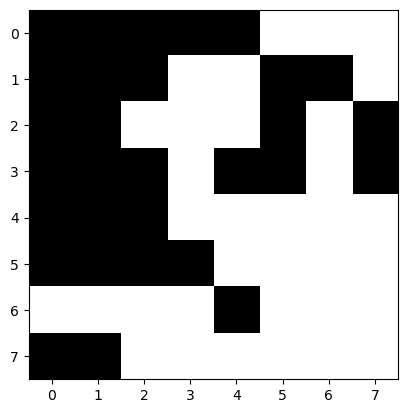

0.2


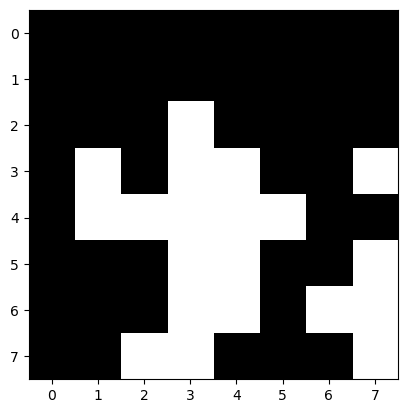

0.2


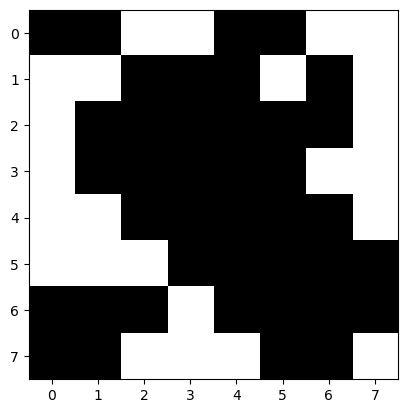

0.2


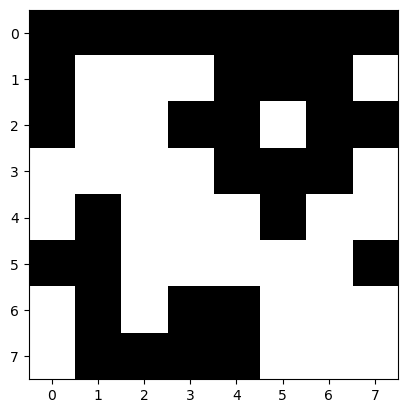

0.2


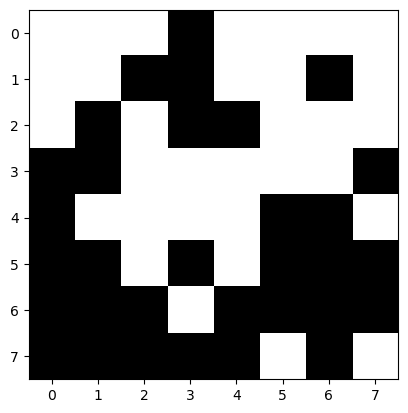

0.2


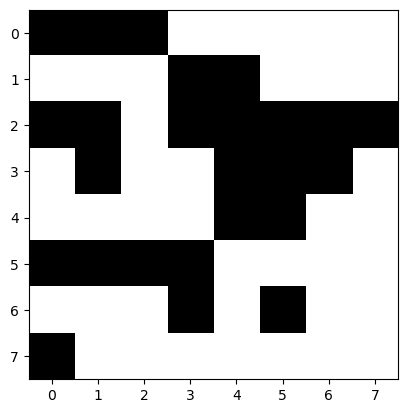

0.2


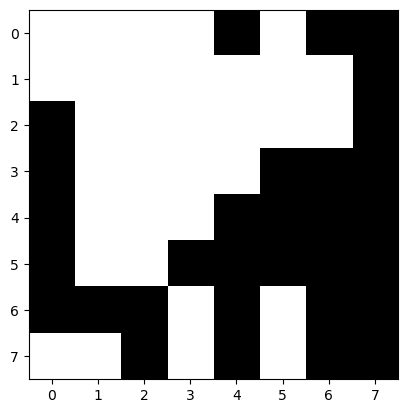

0.2


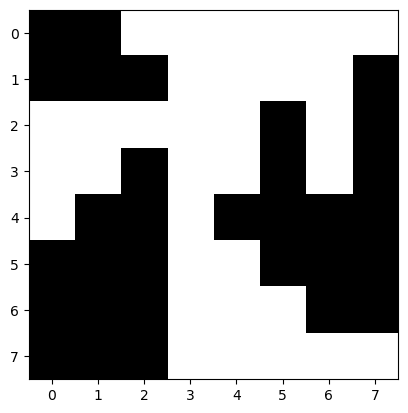

0.2


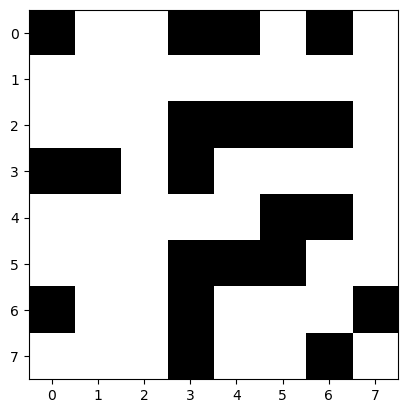

0.2


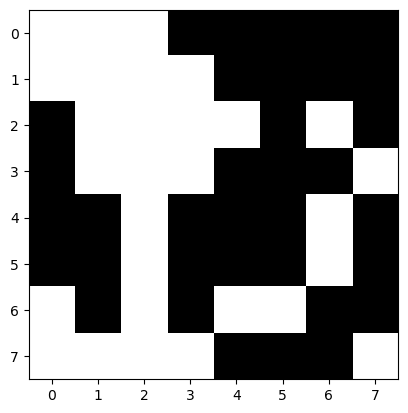

0.2888888888888889


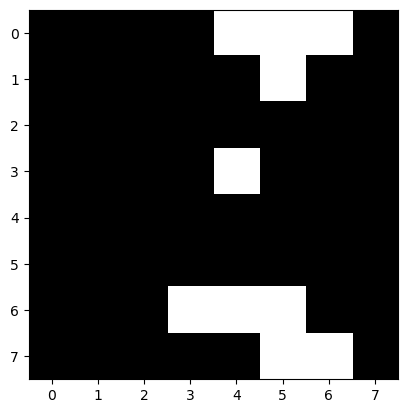

0.2888888888888889


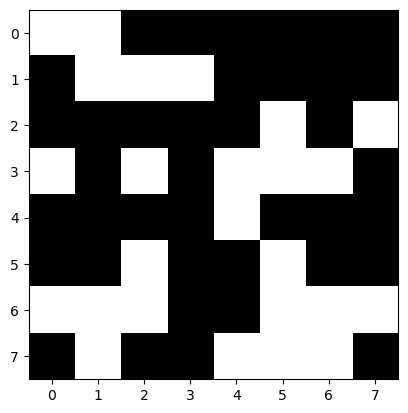

0.2888888888888889


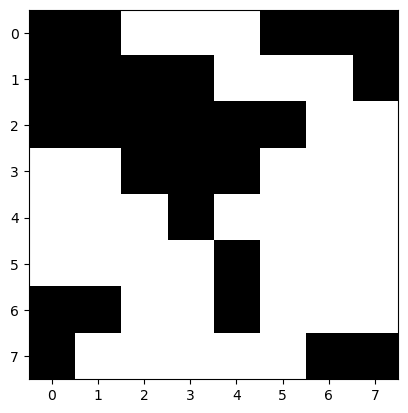

0.2888888888888889


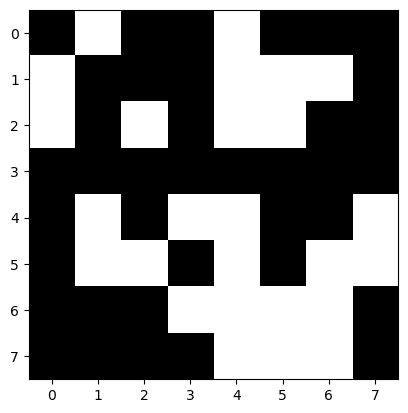

0.2888888888888889


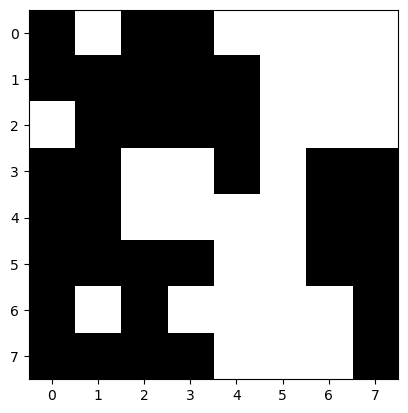

0.2888888888888889


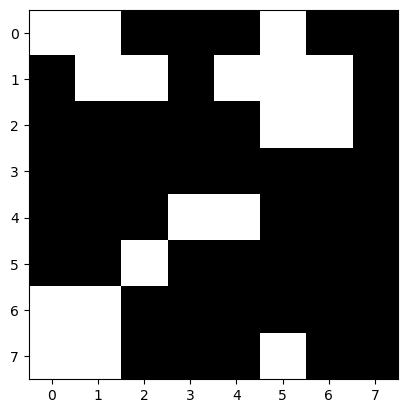

0.2888888888888889


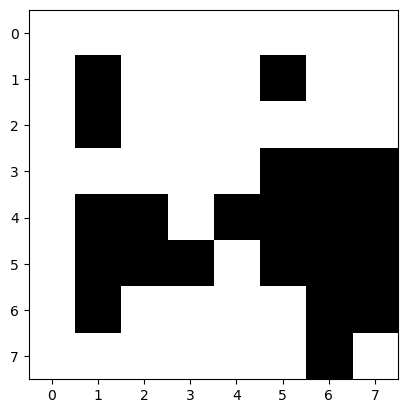

0.2888888888888889


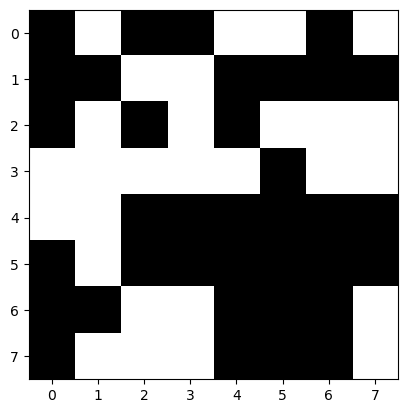

0.2888888888888889


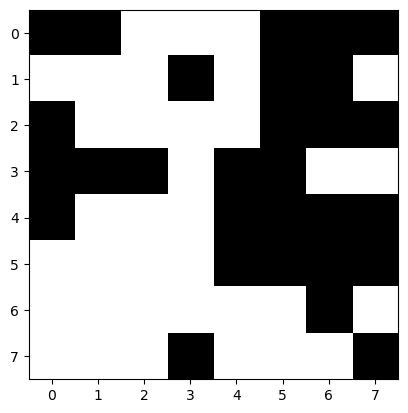

0.2888888888888889


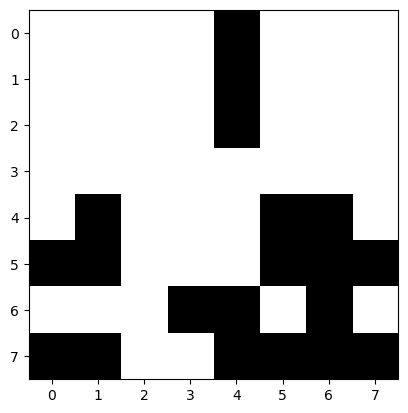

0.37777777777777777


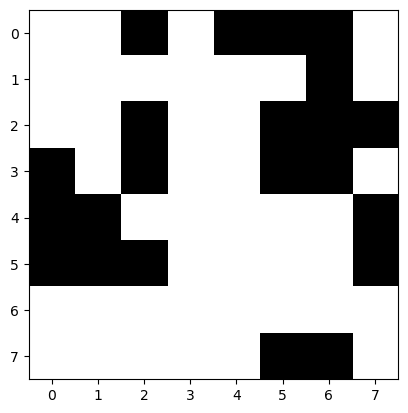

0.37777777777777777


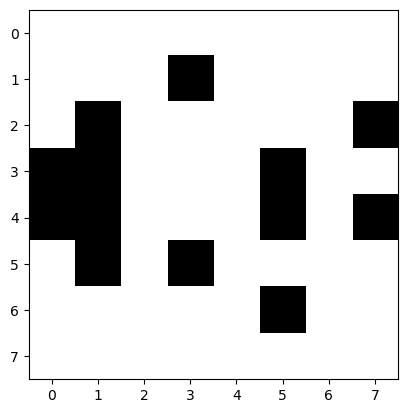

0.37777777777777777


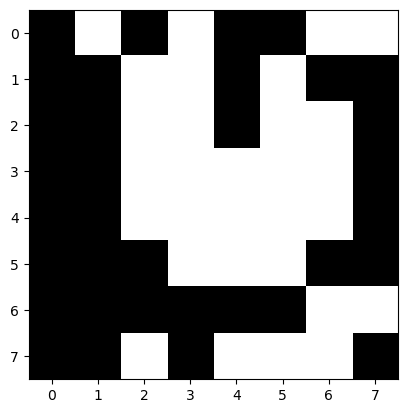

0.37777777777777777


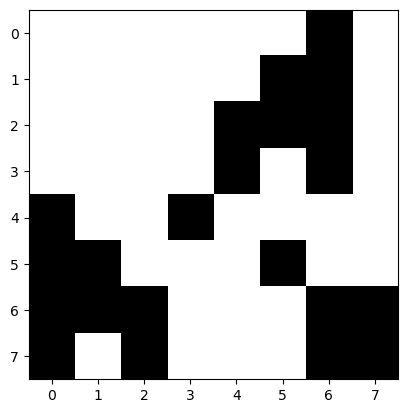

0.37777777777777777


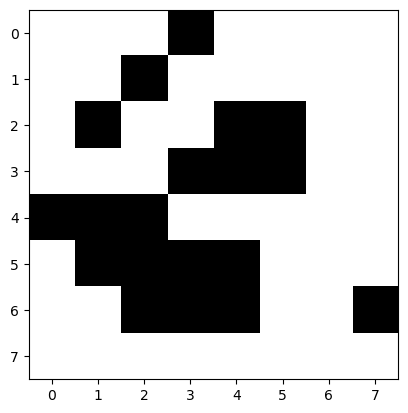

0.37777777777777777


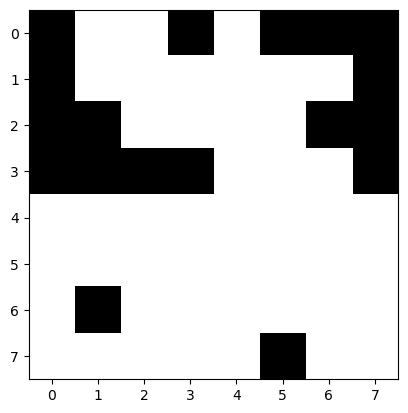

0.37777777777777777


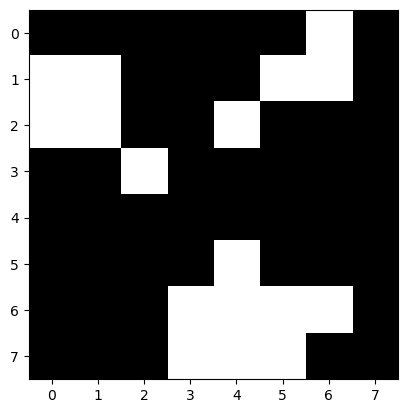

0.37777777777777777


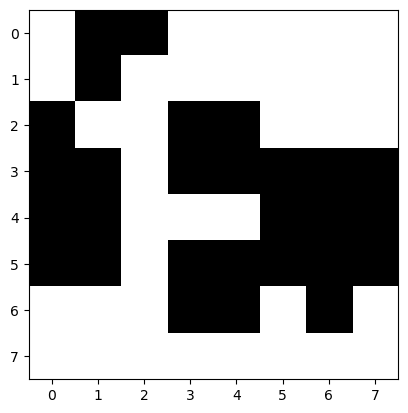

0.37777777777777777


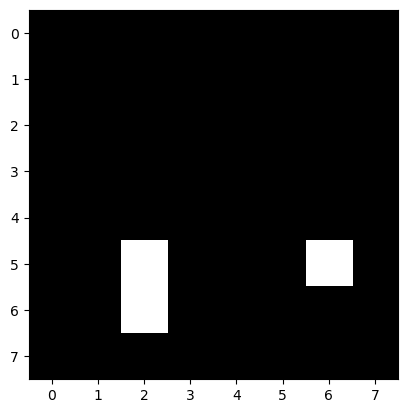

0.37777777777777777


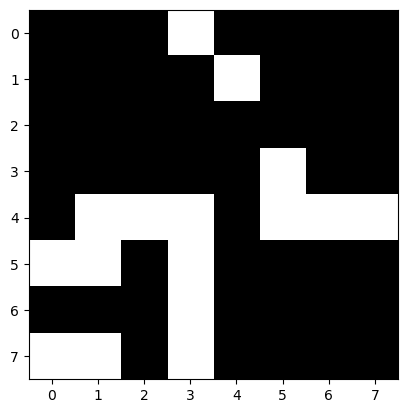

0.4666666666666667


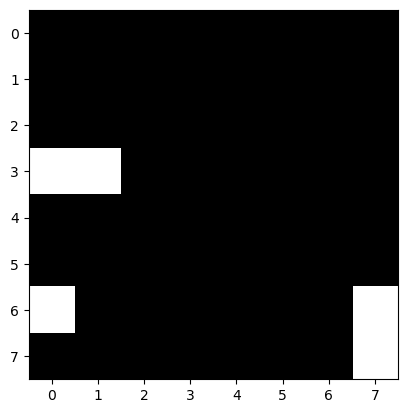

0.4666666666666667


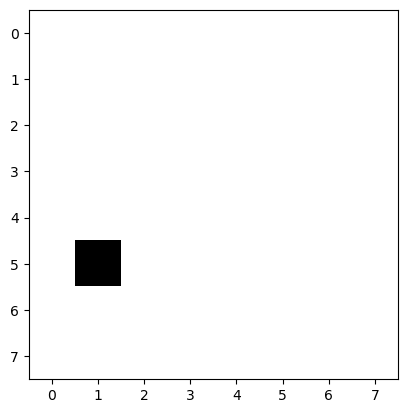

0.4666666666666667


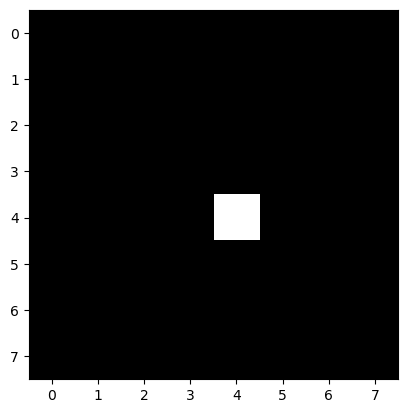

0.4666666666666667


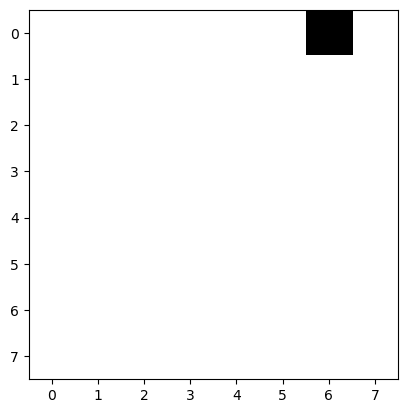

0.4666666666666667


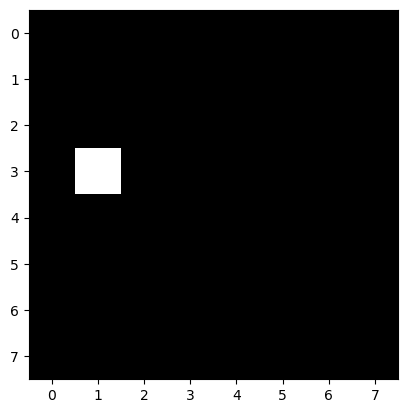

0.4666666666666667


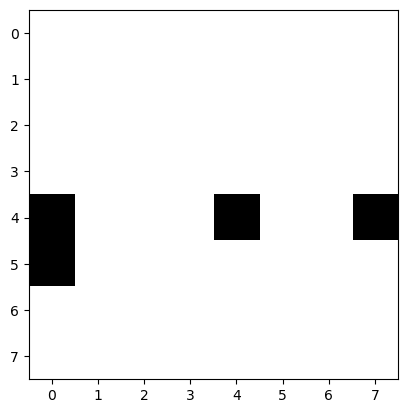

0.4666666666666667


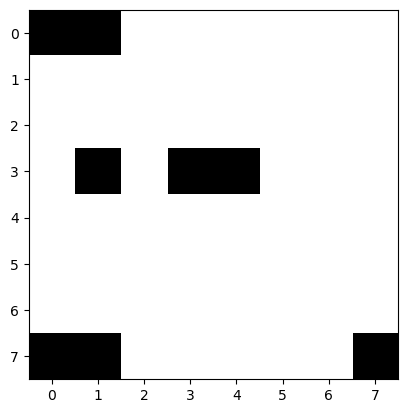

0.4666666666666667


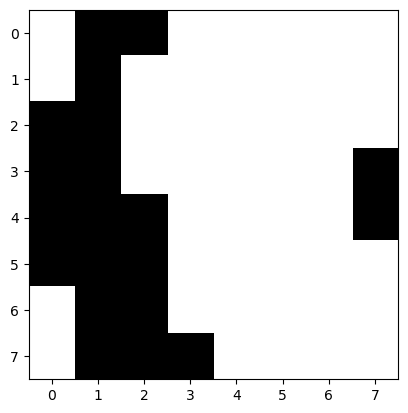

0.4666666666666667


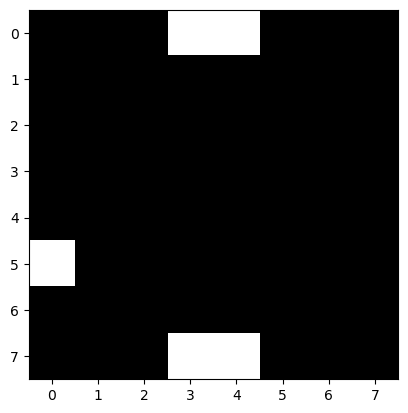

0.4666666666666667


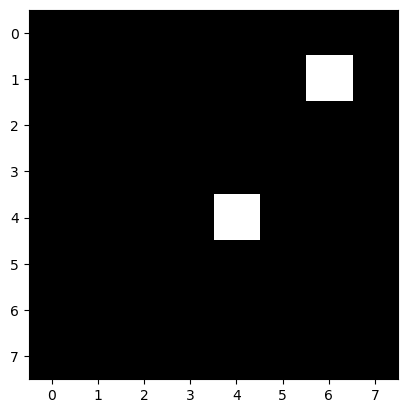

0.5555555555555556


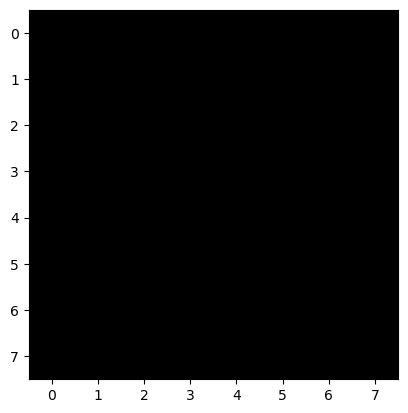

0.5555555555555556


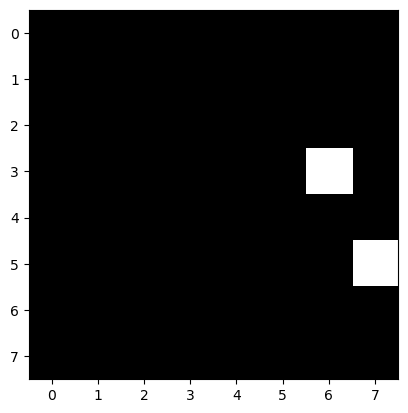

0.5555555555555556


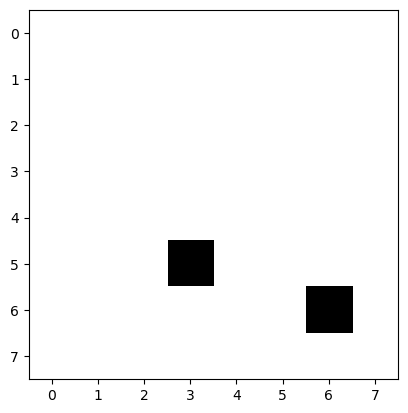

0.5555555555555556


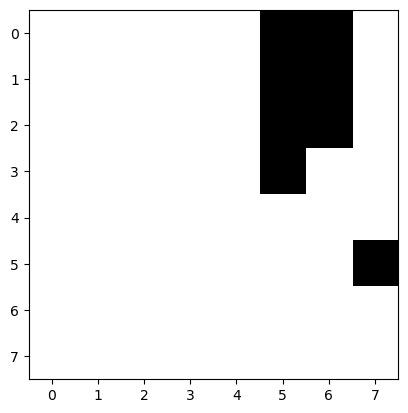

0.5555555555555556


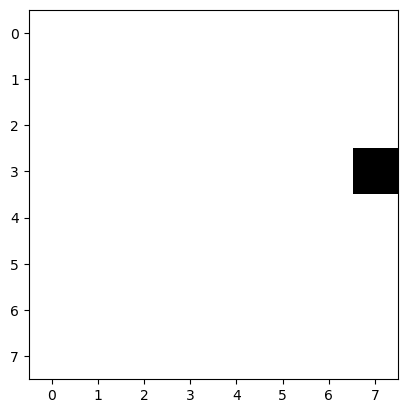

0.5555555555555556


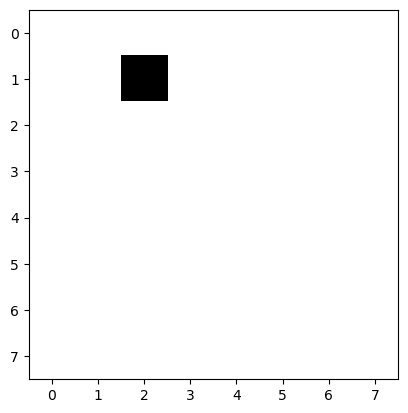

0.5555555555555556


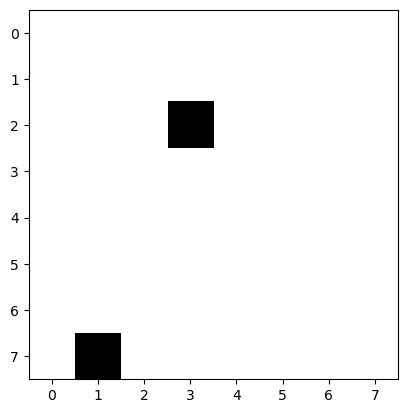

0.5555555555555556


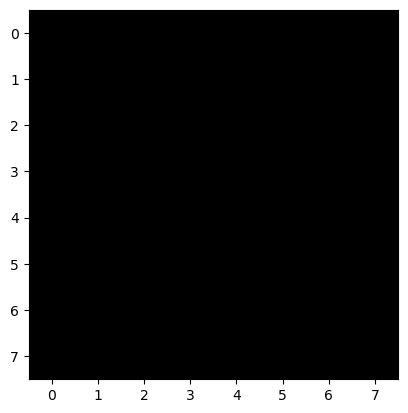

0.5555555555555556


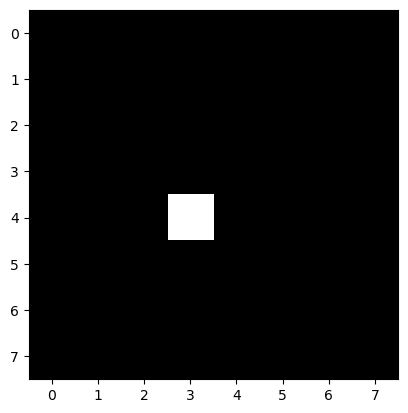

0.5555555555555556


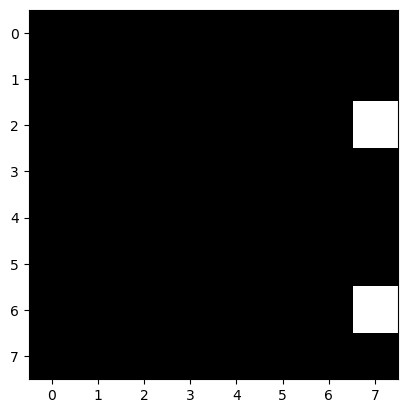

0.6444444444444445


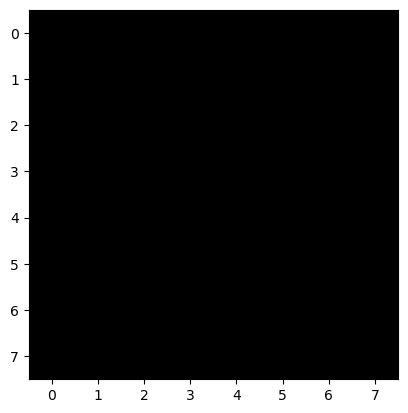

0.6444444444444445


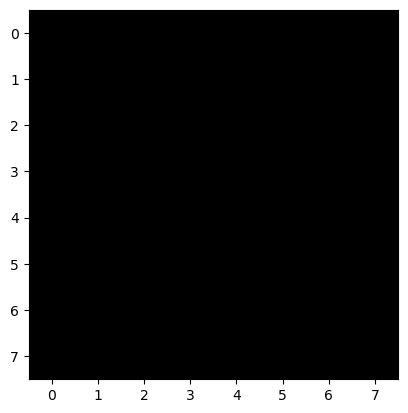

0.6444444444444445


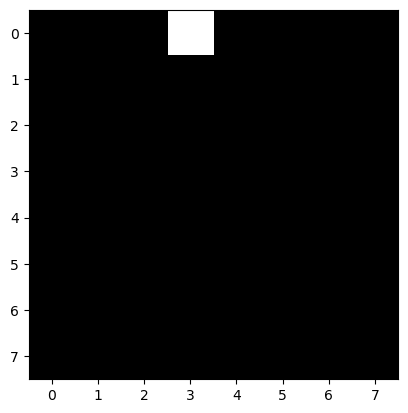

0.6444444444444445


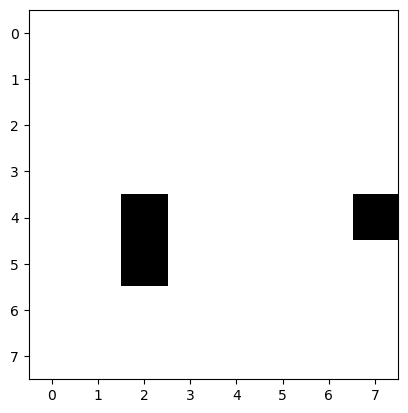

0.6444444444444445


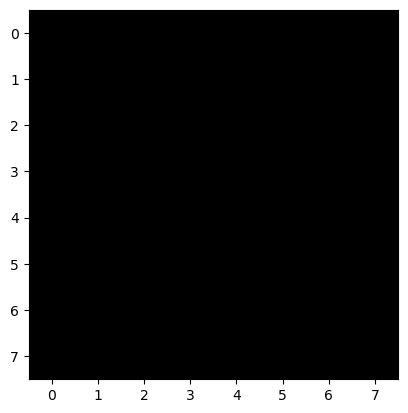

0.6444444444444445


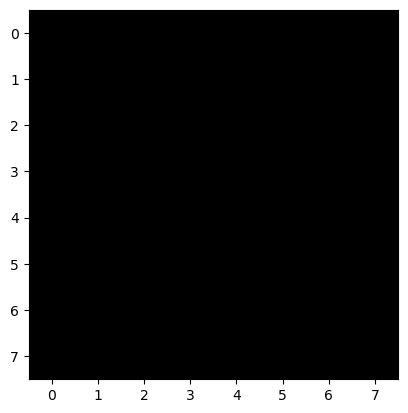

0.6444444444444445


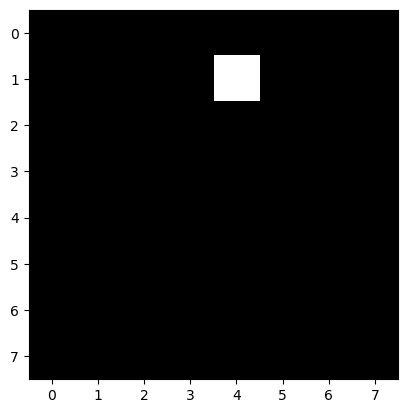

0.6444444444444445


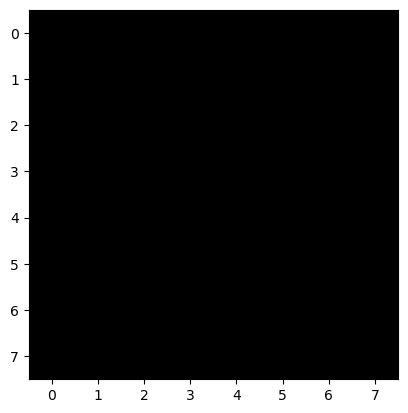

0.6444444444444445


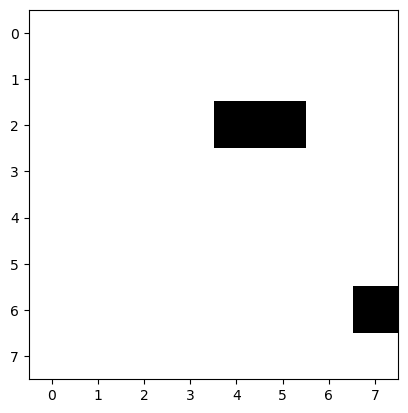

0.6444444444444445


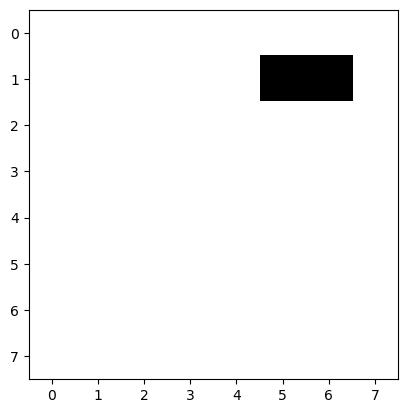

0.7333333333333334


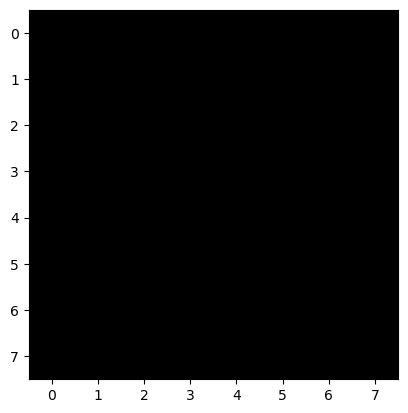

0.7333333333333334


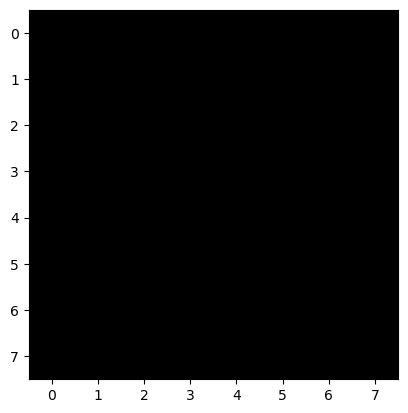

0.7333333333333334


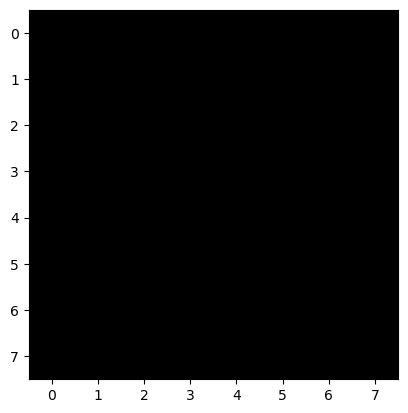

0.7333333333333334


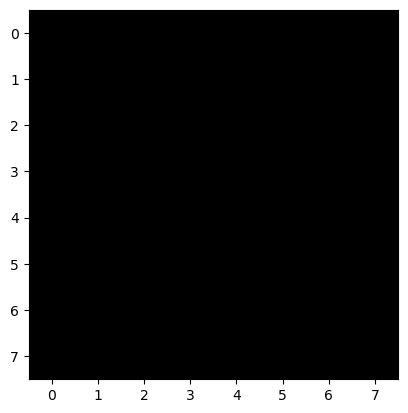

0.7333333333333334


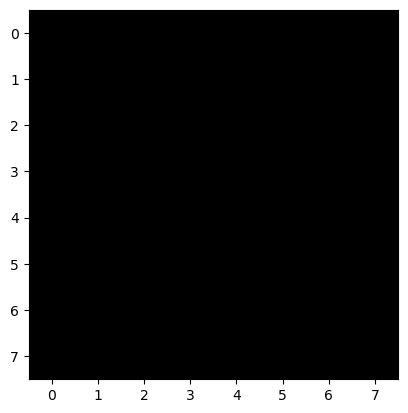

0.7333333333333334


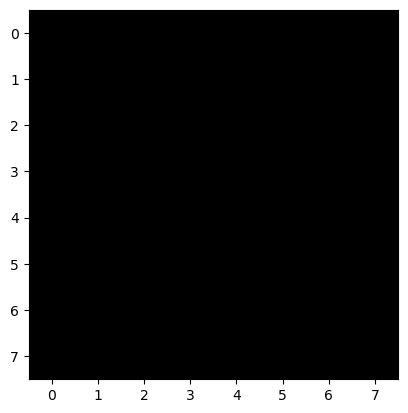

0.7333333333333334


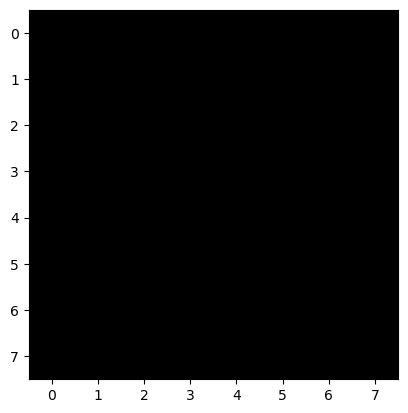

0.7333333333333334


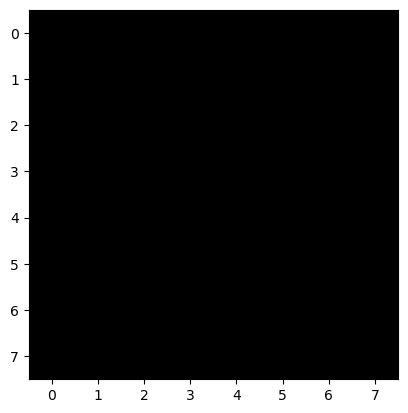

0.7333333333333334


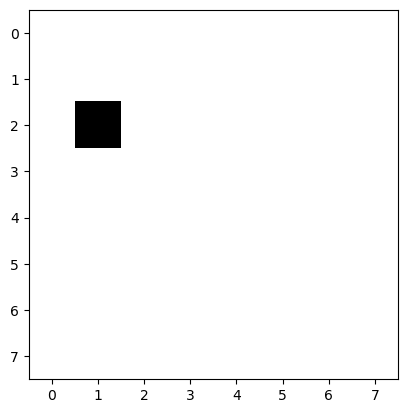

0.7333333333333334


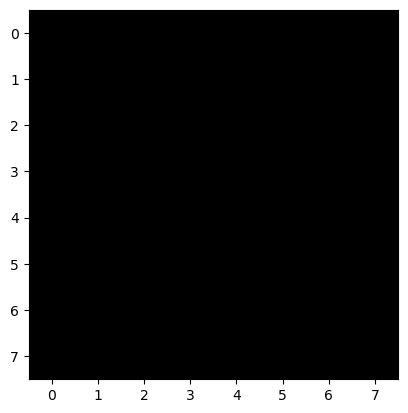

0.8222222222222222


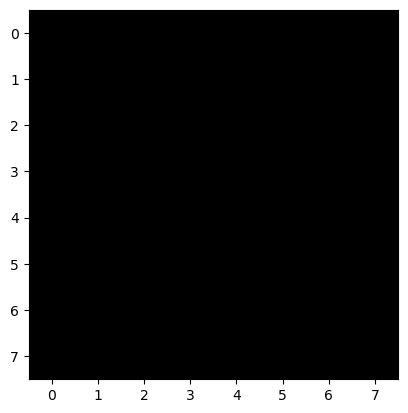

0.8222222222222222


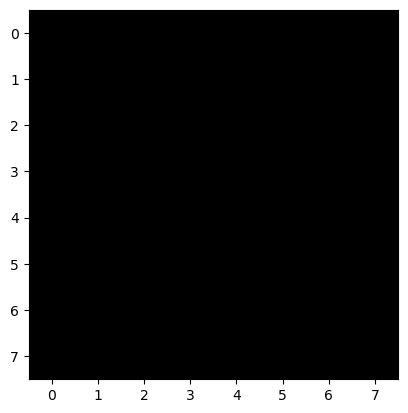

0.8222222222222222


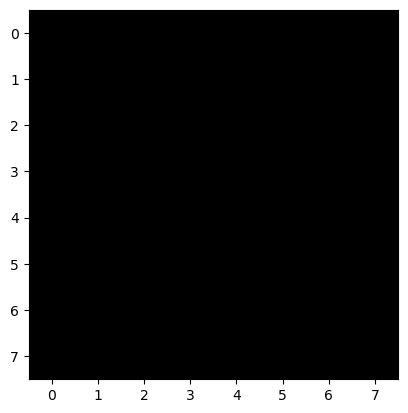

0.8222222222222222


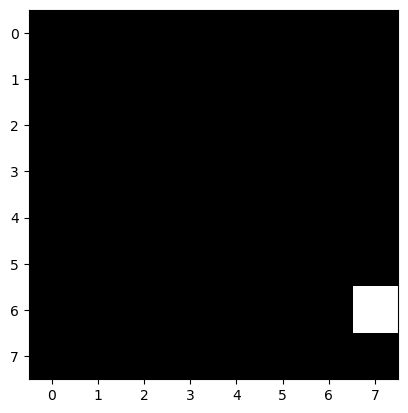

0.8222222222222222


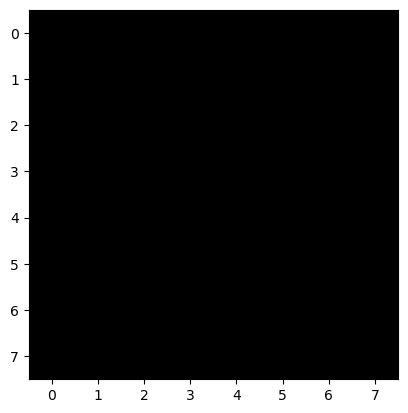

0.8222222222222222


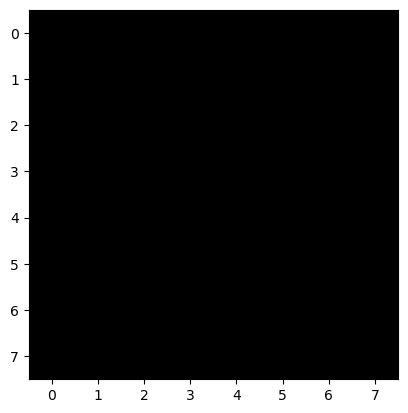

0.8222222222222222


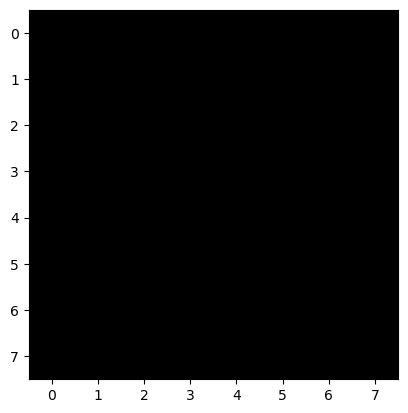

0.8222222222222222


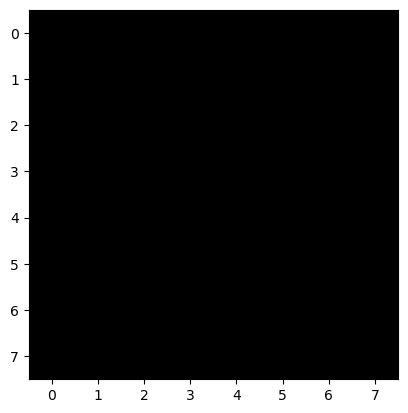

0.8222222222222222


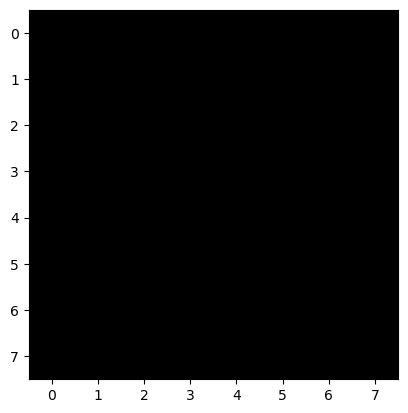

0.8222222222222222


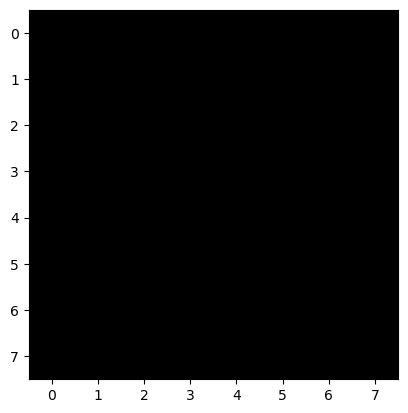

0.9111111111111112


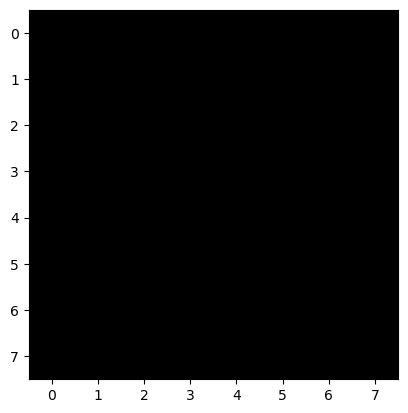

0.9111111111111112


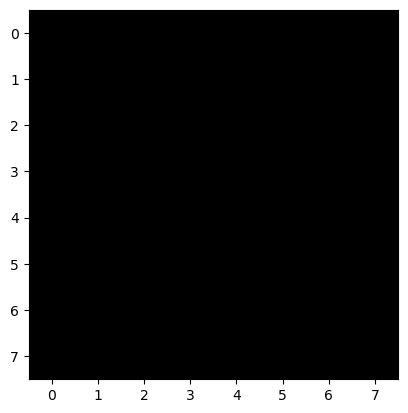

0.9111111111111112


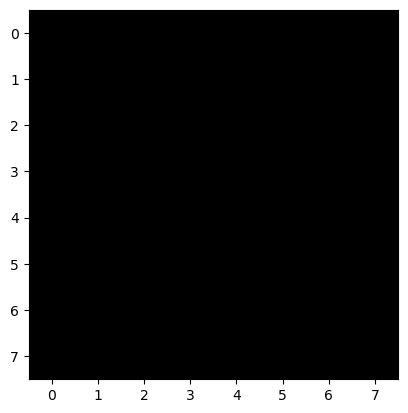

0.9111111111111112


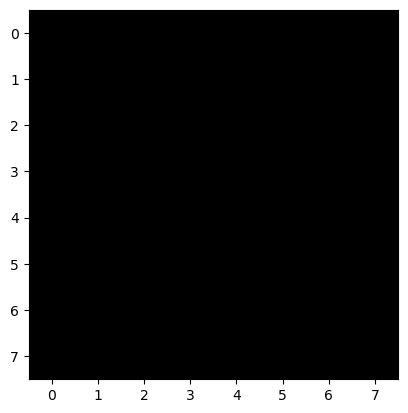

0.9111111111111112


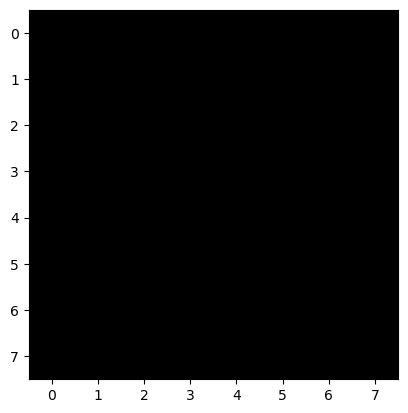

0.9111111111111112


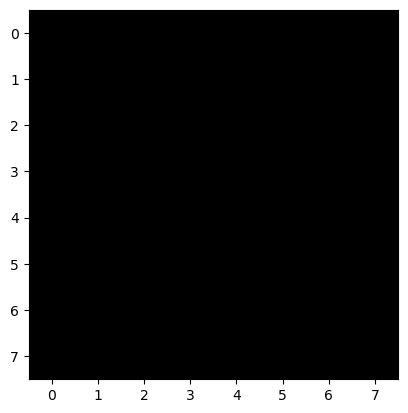

0.9111111111111112


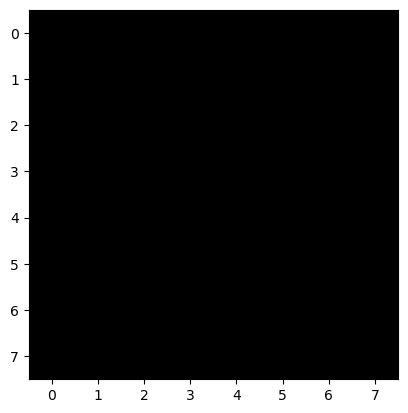

0.9111111111111112


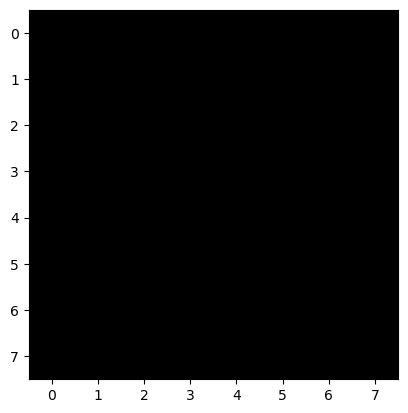

0.9111111111111112


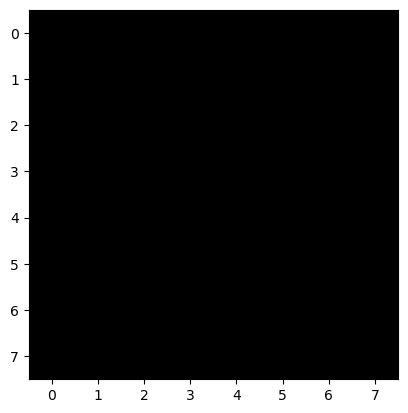

0.9111111111111112


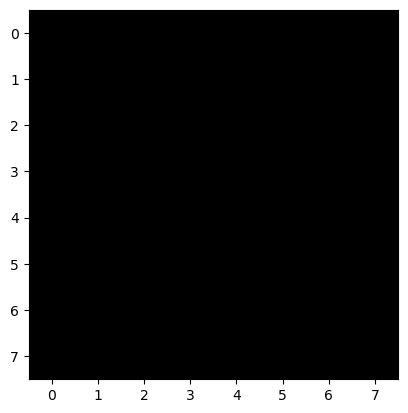

1.0


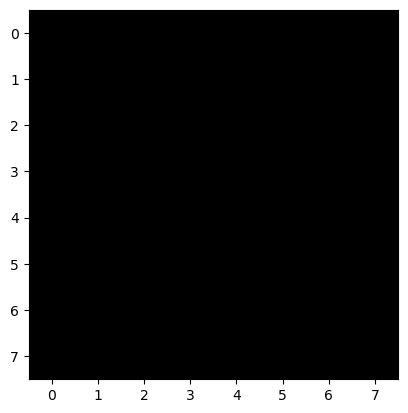

1.0


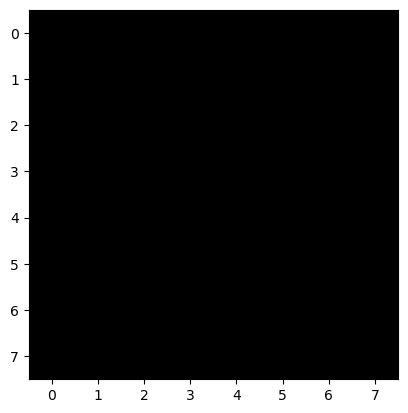

1.0


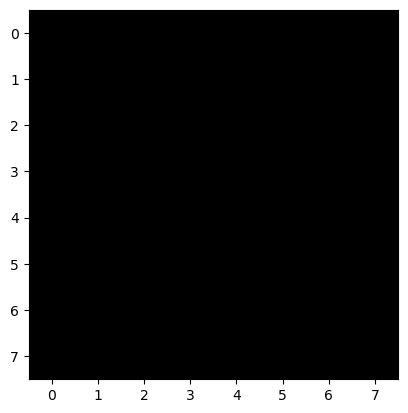

1.0


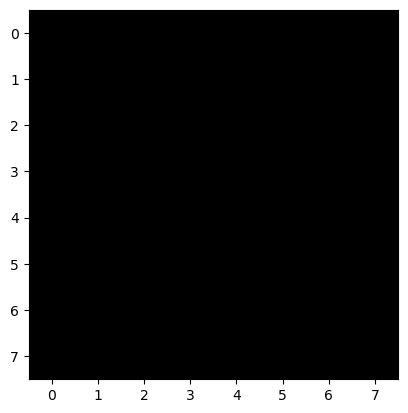

1.0


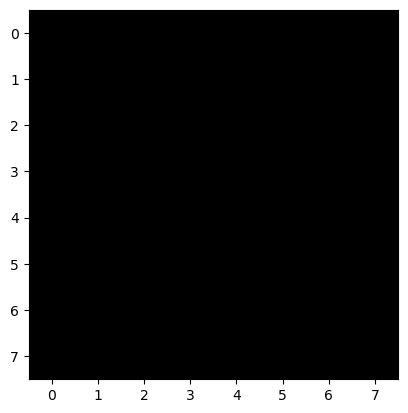

1.0


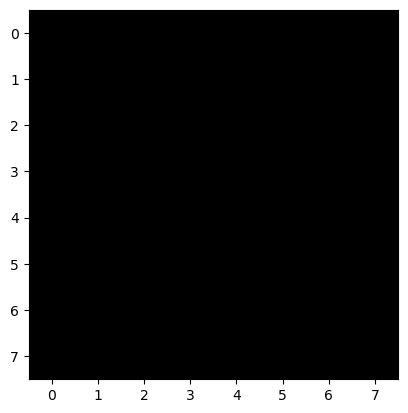

1.0


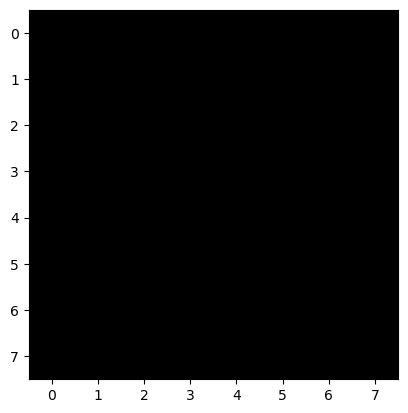

1.0


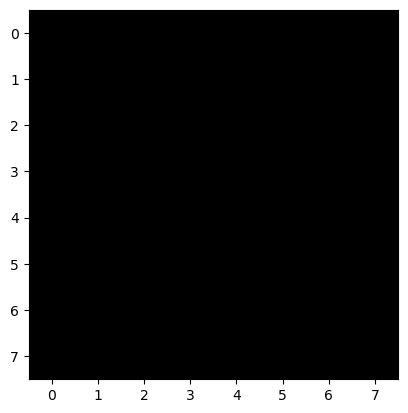

1.0


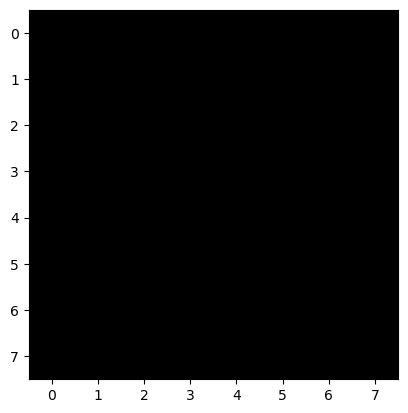

1.0


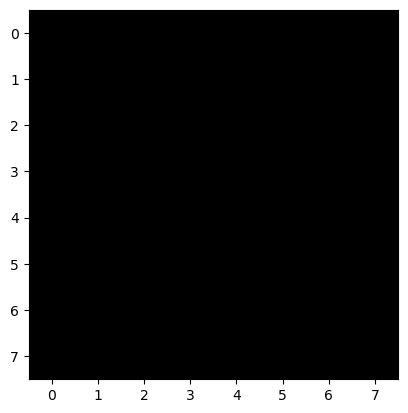

In [7]:
# i = 10
# print(spin_data[i])
# print(temp_data[i])

for i in range(100):
    # CUDAデバイス上のテンソルをCPU上のNumPy配列に変換
    spin_data_cpu = spin_data[i].cpu().numpy()

    print(temp_data[i])
    # CUDAデバイス上のテンソルをCPU上のNumPy配列に変換
    plt.imshow(spin_data_cpu, cmap='gray', interpolation='nearest')
    plt.show()

In [8]:
# # 保存するデータをtupleにまとめる
# data_to_save = (spin_data, temp_data)

# # フォルダ名とファイル名を指定
# folder_name = "Data"
# file_name = 'Isig_samp_data_L8.pkl'

# # データをバイナリ形式で保存
# file_path = os.path.join(folder_name, file_name)
# with open(file_path, 'wb') as file:
#     pickle.dump(data_to_save, file)

In [9]:
spin_data[1]

tensor([[-1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1.,  1., -1.,  1.,  1., -1., -1.,  1.],
        [-1.,  1.,  1.,  1.,  1.,  1., -1., -1.],
        [-1., -1., -1.,  1.,  1., -1., -1.,  1.],
        [-1., -1., -1.,  1.,  1., -1.,  1.,  1.],
        [-1., -1.,  1.,  1., -1., -1., -1.,  1.]])

In [10]:
temp_data[1]

0.2